In [ ]:
import os
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_colors_dict, featre_to_tick
import pickle

save_root = 'explain_features/domain_classification/'
os.makedirs(save_root, exist_ok=True)
discov_val_feats_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_clinical_merged.csv'
# discov_val_feats_path = '/home/u2070124/lsf_workspace/Data/Data/pancancer/tcga_features_clinical_merged.csv'
discov_df = pd.read_csv(discov_val_feats_path)
feats_list = pd.read_csv('noncorrolated_feature_list_2.csv', header=None)[0].to_list()
feats_list = [feat for feat in feats_list if feat not in ["mit_clusterCoff_max", "mit_hotspot_score"]]

df = discov_df[['type']+feats_list]
invalid_cancers = ['PCPG','DLBC','THYM','LAML','SARC','CHOL','ACC']
df = df[~df['type'].isin(invalid_cancers)]
df['type'] = df['type'].replace('COAD', 'COADREAD')
df['type'] = df['type'].replace('READ', 'COADREAD')
domains = df['type'].unique()

# Separate features and target
X = df[feats_list]
y = df['type']


coefs_dict = {domain: {feat: [] for feat in feats_list} for domain in domains}
# features_dict = {feat: [] for feat in feats_list}


# Standardize the features
scaler = StandardScaler()

# Initialize the classifier
clf = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True, random_state=42), n_jobs=4, verbose=0)

# Number of bootstrap iterations
n_iterations = 4

# Store the AUROC for each bootstrap iteration
aucs_dict = {domain: [] for domain in domains}


for i in tqdm(range(n_iterations)):
    # Create train and test splits
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train the classifier
    clf.fit(X_train, y_train)

    # Compute AUCs for each domain performance separately and save it into the aucs_dict
    y_score = clf.predict_proba(X_test)
    for j, domain in enumerate(clf.classes_):
        y_true = (y_test == domain).astype(int)
        aucs_dict[domain].append(roc_auc_score(y_true, y_score[:, j]))

    # Collect the coefficient of estimators related to each domain
    for j, estimator in enumerate(clf.estimators_):
        for h, est_coef in enumerate(estimator.coef_.tolist()[0]):
            coefs_dict[clf.classes_[j]][feats_list[h]].append(est_coef)

# save_results to disk
with open(f'{save_root}/bootstrap_coefs_data.pkl', 'wb') as handle:
    pickle.dump(coefs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# plotting classification performance per domain
gap = 10
width = 8
color_dict = get_colors_dict()

fig = plt.figure(figsize=(15,3))  # Increase the figure size
ax = fig.add_subplot(111)
for i, domain in enumerate(domains):
    box1 = ax.boxplot(aucs_dict[domain], positions=[i*gap], widths=width, patch_artist=True, showfliers=False, boxprops=dict(facecolor=color_dict[domain]), medianprops=dict(color='black'))

ax.set_xticks(range(0, len(domains) * gap, gap))
ax.set_xticklabels(domains)

plt.xlim([-1*width, i*gap+1*width])

# Set the title and labels
plt.title(f'Domain Classification Performance')
plt.xlabel('Domains')
plt.ylabel('AUROC')

plt.savefig(f"{save_root}/Domain_Classification_Performance.png", bbox_inches='tight', dpi=600)

# For each feature
coefs_df = pd.DataFrame(coefs_dict).T
# For each feature
for i, feat in enumerate(feats_list):
    fig = plt.figure(figsize=(15,3))  # Increase the figure size
    ax = fig.add_subplot(111)

    
    for i, domain in enumerate(domains):
        box1 = ax.boxplot(coefs_df[feat][domain], positions=[i*gap], widths=width, patch_artist=True, showfliers=False, boxprops=dict(facecolor=color_dict[domain]), medianprops=dict(color='black'))

    ax.set_xticks(range(0, len(domains) * gap, gap))
    ax.set_xticklabels(domains)

    plt.xlim([-1*width, i*gap+1*width])
    
    # Set the title and labels
    # plt.title(f'Distribution of Coefficients for {feat}')
    plt.xlabel('Domains')
    plt.ylabel(featre_to_tick(feat))


    plt.savefig(f"{save_root}/importance-{feat}.png", bbox_inches='tight', dpi=600)


# plot without LGG
for i, feat in enumerate(feats_list):
    fig = plt.figure(figsize=(15,3))  # Increase the figure size
    ax = fig.add_subplot(111)

    
    for i, domain in enumerate(domains):
        if domain == 'LGG':
            continue
        box1 = ax.boxplot(coefs_df[feat][domain], positions=[i*gap], widths=width, patch_artist=True, showfliers=False, boxprops=dict(facecolor=color_dict[domain]), medianprops=dict(color='black'))

    ax.set_xticks(range(0, len(domains) * gap, gap))
    ax.set_xticklabels(domains)

    # plt.xlim([-1*width, i*gap+1*width])
    
    # Set the title and labels
    # plt.title(f'Distribution of Coefficients for {feat}')
    plt.xlabel('Domains')
    plt.ylabel(featre_to_tick(feat))


    plt.savefig(f"{save_root}/importance-{feat}.png", bbox_inches='tight', dpi=600)

In [1]:
# load the data and results
import os
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from utils import get_colors_dict, featre_to_tick
import pickle

save_root = 'explain_features/domain_classification_withPCPG_Balanced/'
os.makedirs(save_root, exist_ok=True)
discov_val_feats_path = '/mnt/gpfs01/lsf-workspace/u2070124/Data/Data/pancancer/tcga_features_clinical_merged.csv'
# discov_val_feats_path = '/home/u2070124/lsf_workspace/Data/Data/pancancer/tcga_features_clinical_merged.csv'
discov_df = pd.read_csv(discov_val_feats_path)
feats_list = pd.read_csv('noncorrolated_feature_list_2.csv', header=None)[0].to_list()
feats_list = [feat for feat in feats_list if feat not in ["mit_clusterCoff_max", "mit_hotspot_score"]]

df = discov_df[['type']+feats_list]
invalid_cancers = ['DLBC','THYM','LAML','SARC','CHOL','ACC']
df = df[~df['type'].isin(invalid_cancers)]
df['type'] = df['type'].replace('COAD', 'COADREAD')
df['type'] = df['type'].replace('READ', 'COADREAD')
domains = df['type'].unique()

with open(f'{save_root}/bootstrap_coefs_data.pkl', 'rb') as handle:
    coefs_dict = pickle.load(handle)
coefs_df = pd.DataFrame(coefs_dict).T

with open(f'{save_root}/bootstrap_auc_data.pkl', 'rb') as handle:
    aucs_dict = pickle.load(handle)

with open(f'{save_root}/bootstrap_f1_data.pkl', 'rb') as handle:
    f1_dict = pickle.load(handle)

color_dict = get_colors_dict()

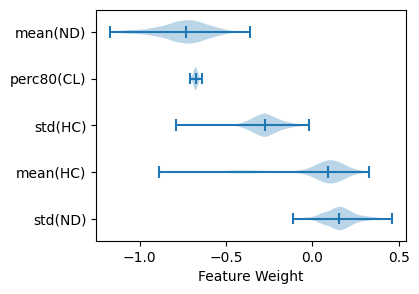

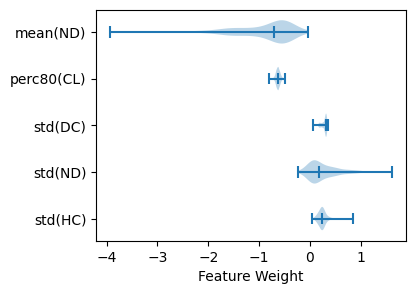

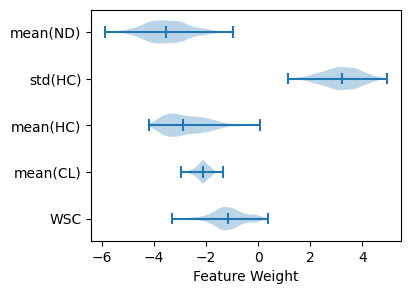

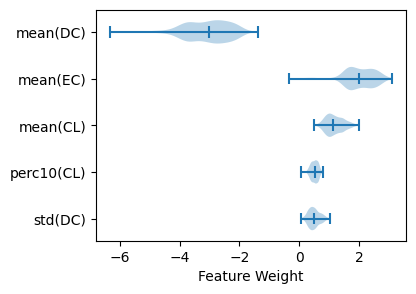

In [15]:
def find_top_features(coefs_df, domain, feats_list, top_k):
    feat_means = []
    for feat in feats_list:
        feat_vals = coefs_df[feat][domain]
        feat_means.append(np.mean(np.abs(feat_vals)))
    feat_df = pd.DataFrame([feats_list, feat_means]).T
    feat_df.columns=['name', 'value']
    feat_df =feat_df.sort_values('value', ascending=False).head(top_k)
    return feat_df['name'].to_list()[::-1]

top_k = 5
gap = 10
width = 8
color_dict = get_colors_dict()

domains = ['KIRC', 'LGG', 'PCPG', 'CESC']

for i, domain in enumerate(domains):

    fig = plt.figure(figsize=(4,3))  # Increase the figure size
    # ax = fig.add_subplot(111)

    top_feats= find_top_features(coefs_df, domain, feats_list, 5)
    feat_list_fancy = [featre_to_tick(feat) for feat in top_feats]
    data = []
    for i, feat in enumerate(top_feats):
        data.append(coefs_df[feat][domain])
    data= np.transpose(np.array(data))
    plt.violinplot(data,showmedians=True,showextrema=True,vert=False,widths=0.5)
    plt.yticks(list(np.arange(1,len(feat_list_fancy)+1)), feat_list_fancy)
    plt.yticks(rotation=0)
    plt.xlabel('Feature Weight')

    plt.savefig(f"{save_root}/{domain}-featureWeight-{feat}.pdf", bbox_inches='tight', dpi=600)
    plt.savefig(f"{save_root}/{domain}-featureWeight-{feat}.png", bbox_inches='tight', dpi=600)

    # for i, feat in enumerate(top_feats):
    #     box1 = ax.violinplot(coefs_df[feat][domain], positions=[i*gap], widths=width, showmedians=True,showextrema=True,vert=False)

    # ax.set_yticks(range(0, len(feat_list_fancy) * gap, gap))
    # ax.set_yticklabels(feat_list_fancy)

    # plt.ylim([-1*width, i*gap+1*width])
    
    # Set the title and labels
    # plt.title(f'Distribution of Coefficients for {feat}')
    # plt.xlabel('Domains')

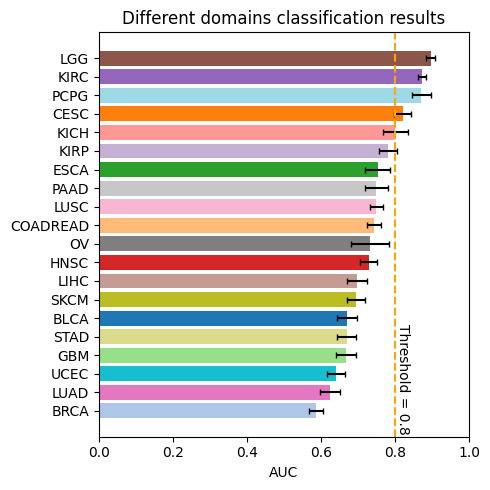

In [3]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(5,5)) 

# Assuming 'results' is your dictionary of AUC results
metr = "AUC"
results = aucs_dict if metr=="AUC" else f1_dict
# results = f1_dict
# Calculate means and standard deviations
means = {k: np.mean(v) for k, v in results.items()}
std_devs = {k: np.std(v) for k, v in results.items()}

colors = [color_dict[domain] for domain in results.keys()]

# Sort the 'means' and 'std_devs' dictionaries by their values in descending order
sorted_domains = sorted(means, key=means.get, reverse=False)
sorted_means = [means[domain] for domain in sorted_domains]
sorted_std_devs = [std_devs[domain] for domain in sorted_domains]
sorted_colors = [color_dict[domain] for domain in sorted_domains]

# Create horizontal bar plot with error bars
plt.barh(range(len(results)), sorted_means, xerr=sorted_std_devs, align='center', alpha=1, ecolor='black', capsize=2, color=sorted_colors)
plt.yticks(range(len(results)), sorted_domains)

threshold = 0.8 if metr=="AUC" else 0.2
plt.axvline(x=threshold, color='orange', linestyle='--')

# plt.yticks(range(len(results)), list(results.keys()))
plt.xlabel(metr.upper())
x_range = [0, 1] if metr=="AUC" else [0, 0.5]
plt.xlim(x_range) # [0, 1]
plt.title('Different domains classification results')
# plt.legend(['Threshold = 0.75'], loc=4)
# plt.xticks(list(plt.xticks()[0]) + [threshold])
plt.text(threshold+0.04, plt.gca().get_ylim()[0]+.1, f"Threshold = {threshold}", color='black', va='bottom', ha='right', rotation=270)
plt.tight_layout()

plt.savefig(f"{save_root}/Domain_Classification_Performance_Bars_{metr.upper()}.pdf", bbox_inches='tight', dpi=600)
plt.savefig(f"{save_root}/Domain_Classification_Performance_Bars_{metr.upper()}.png", bbox_inches='tight', dpi=600)



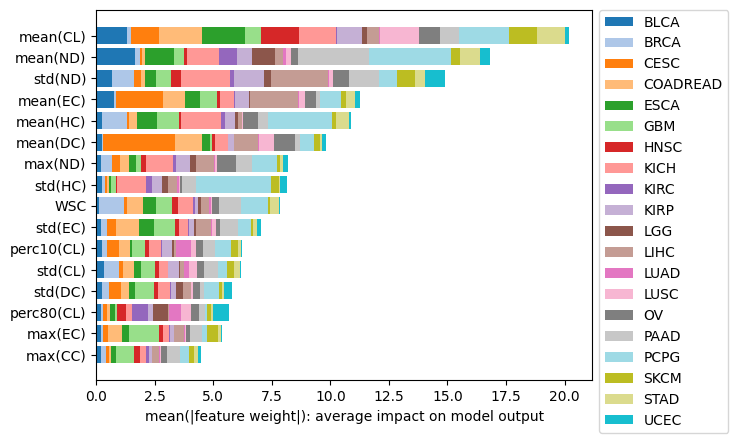

In [4]:
def plot_mean_abs_coefs(coefs_dict, color_dict, skip_lgg=False):
    domains = list(coefs_dict.keys())
    # Calculate mean absolute values
    if skip_lgg:
        mean_abs_coefs = {domain: {feat: np.mean(np.abs(coefs)) for feat, coefs in domain_dict.items()} for domain, domain_dict in coefs_dict.items() if domain != "LGG" }
        domains_ = domains.tolist()
        domains_.remove("LGG")
    else:    
        mean_abs_coefs = {domain: {feat: np.mean(np.abs(coefs)) for feat, coefs in domain_dict.items()} for domain, domain_dict in coefs_dict.items()}
        domains_ = domains

    # Calculate the sum of mean absolute values per feature
    sum_mean_abs_coefs = {feat: sum(domain_dict[feat] for domain_dict in mean_abs_coefs.values()) for feat in feats_list}

    # Sort features by the sum of mean absolute values in descending order
    sorted_feats = sorted(feats_list, key=lambda feat: sum_mean_abs_coefs[feat], reverse=False)

    # Create figure and axes
    fig, ax = plt.subplots()

    # For each feature
    for i, feat in enumerate(sorted_feats):
        # Initialize the left side of the bar
        left = 0

        # For each domain
        for domain in domains_:
            # Get the mean absolute coefficient for the current feature and domain
            mean_abs_coef = mean_abs_coefs[domain][feat]

            # Add a bar to the plot
            ax.barh(i, mean_abs_coef, left=left, color=color_dict[domain], alpha=1)

            # Update the left side of the bar
            left += mean_abs_coef

    # Set the y-axis labels to be the features
    ax.set_yticks(range(len(sorted_feats)))
    ax.set_yticklabels([featre_to_tick(feat) for feat in sorted_feats])

    # Add a legend outside the plot box
    ax.legend(domains_, bbox_to_anchor=(1.0, 1.02), loc='upper left')

    plt.xlabel("mean(|feature weight|): average impact on model output")
    # Show the plot
    plt.show()
    return fig

# Call the function to plot the mean absolute coefficients
fig = plot_mean_abs_coefs(coefs_dict, color_dict)
fig.savefig(f"{save_root}/coefs_mean_absolute.pdf", bbox_inches='tight', dpi=600)
fig.savefig(f"{save_root}/coefs_mean_absolute.png", bbox_inches='tight', dpi=600)

# fig = plot_mean_abs_coefs(coefs_dict, color_dict, skip_lgg=True)
# fig.savefig(f"{save_root}/coefs_mean_absolute_woLGG.pdf", bbox_inches='tight', dpi=600)
# fig.savefig(f"{save_root}/coefs_mean_absolute_woLGG.png", bbox_inches='tight', dpi=600)
